# Setup

In [ ]:
# Global Settings
SEED = 1
DIM = 512
EPOCHS = 25
BATCH_SIZE = 32
NUM_CLASSES = 1
VERBOSE_LEVEL = 1
META_CONTRIBUTION = 0.1

LR_MAX = 1e-4
LR_MIN = 1e-8
LR_START = 1e-4
FIND_LR = False
SAVE_OUTPUT = True
USE_TENSORBOARD = False

In [ ]:
%%capture
!pip install efficientnet

In [ ]:
import os
import re
import gc
import sys
import glob
import math
import json
import shutil
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from functools import partial
from joblib import dump, load
import matplotlib.pyplot as plt
import efficientnet.keras as efn 
from datetime import datetime, date
from pandas.core.common import flatten
from IPython.display import clear_output
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model

In [ ]:
# cleanup
for f in glob.glob("/content/*.png"):
    os.remove(f)

for f in glob.glob("/content/*.hdf5"):
    os.remove(f)

for f in glob.glob("/content/*.txt"):
    os.remove(f)

for f in glob.glob("/content/*.h5"):
    os.remove(f)

for f in glob.glob("/content/*.json"):
    os.remove(f)

!rm -rf logs

In [ ]:
%%capture
!rm -rf /content/melanoma-classification
!rm -rf /content/sample_data/

# if we do not have the data
if not os.path.exists("/content/melanoma-classification/README.md"):
    # install kaggle
    !pip install kaggle

    # get kaggle auth file
    path_to_auth_file = "kaggle.json"
    if not os.path.exists(path_to_auth_file):
        path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/kaggle.json'

    # read the kaggle.json file
    with open(path_to_auth_file) as json_file:
        data = json.load(json_file)
        os.environ['KAGGLE_USERNAME'] = data["username"]
        os.environ['KAGGLE_KEY'] = data["key"]

    # remove sample data so we have more space
    !rm -rf /content/sample_data

    # download kaggle dataset
    !kaggle datasets download -d saschamet/melanoma-1-12
    !unzip /content/melanoma-1-12.zip
    !rm /content/melanoma-1-12.zip

    ## pull repo
    !git clone https://github.com/SaschaMet/melanoma-classification.git

    ## update repo
    !cd melanoma-classification && git fetch && git pull

    ## switch branch and execute function
    !cd /content/melanoma-classification && git checkout "master" && git fetch && git reset --hard origin/master

In [ ]:
# make sure the repo ist added to the sys path
sys.path.insert(0,'/content/melanoma-classification')
sys.path.insert(1,'/content/melanoma-classification/src')

In [ ]:
# Tensorflow execution optimizations
# Source: https://www.tensorflow.org/guide/mixed_precision & https://www.tensorflow.org/xla
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
except:
    pass

if tpu:
    print("Try connecting to a tpu")
    try:
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        # tf.config.experimental_connect_to_cluster(tpu)
        # tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        REPLICAS = strategy.num_replicas_in_sync
        print("REPLICAS:", REPLICAS)
    except ValueError as error:
        raise BaseException('An exception occurred: {}'.format(error))
    except BaseException as error:
        raise BaseException('An exception occurred: {}'.format(error))
else:
    num_gpus = len(
        tf.config.experimental.list_physical_devices('GPU')
    )
    print("Using default strategy for CPU and single GPU")
    print("Num GPUs Available: ", num_gpus)
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    strategy = tf.distribute.get_strategy()
    REPLICAS = strategy.num_replicas_in_sync
    print("REPLICAS:", REPLICAS)

INFO:tensorflow:Initializing the TPU system: grpc://10.7.106.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.7.106.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Try connecting to a tpu
Running on TPU  ['10.7.106.242:8470']
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [ ]:
if tpu:
    BATCH_SIZE = 128  # increase the batch size if we have a tpu
    USE_TENSORBOARD = False # Tensorboard does not work with tpu

# Set needed env variables based on the global variables
os.environ["DIM"] = str(DIM)
os.environ["BATCH_SIZE"] = str(BATCH_SIZE)

# seed everything
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# environment settings
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.4.1


In [ ]:
%load_ext autoreload
%autoreload 2

# Custom imports
from model.evaluation import evaluate_model
from model.model_callbacks import get_model_callbacks
from model.LearningRateFinder import LearningRateFinder
from data.verify_tf_records import display_batch_of_images
from model.clr_callback import cyclic_learning_rate, get_lr_callback, plot_clr

In [ ]:
## prevent colab shutdown 
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var connection = setInterval(ConnectButton, 60000);

function myStopFunction() {
    console.log("Remove interal"); 
    clearInterval(connection);
}

<IPython.core.display.Javascript object>

# Data Loading, Preparation & Augmentation

## Loading

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
# These files include all malginant images from 2020, 2019, 2018 and 2017 competition as well as data directly from ISIC
# Source: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139
## The first 15 TFRecords contain the malignant images from this years 2020 comp. There are 584 malignant images.
## The next 15 TFRecords contain 580 images downloaded from ISIC's online gallery and are not included in the competition.
## The next 15 even numbered TFRecords contain the malignant images from 2018 2017 comp data.
## The next 15 odd numbered TFRecords contain the malignant images from 2019 new portion comp data. 
## Note: The 2019 Data may decrease the model performance. More Infos here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/168028 
MALIGNANT_IMAGES = tf.io.gfile.glob('gs://kds-e844a28ba4a8e3e8385958e277ef99522d609986c1ac69f6697276ba/*.tfrec')
print("MALIGNANT TF Records", len(MALIGNANT_IMAGES))

# These files include all benign images from the 2020 competition
BENIGN_IMAGES = tf.io.gfile.glob('gs://kds-4a806c5db2ff4ffd43a73448feba6f3cebd0b926323b129523f2e42a/*.tfrec')
print("BENIGN TF Records", len(BENIGN_IMAGES))

# These are the test files from the 2020 competition
TEST_FILENAMES = tf.io.gfile.glob("gs://kds-c736af11d4d3d219d6adf118ffeabab78b00f23e58a5b86473a78fa3/*.tfrec")
print("TEST TF Records", len(TEST_FILENAMES))

MALIGNANT TF Records 60
BENIGN TF Records 163
TEST TF Records 55


In [ ]:
DATA_FROM_2020 = MALIGNANT_IMAGES[0:15]
DATA_ISIC = MALIGNANT_IMAGES[15:30]
DATA_17_18_19 = MALIGNANT_IMAGES[30:60]

# Because 2019 may potentially decrease the model performance, we exlude it
DATA__17_18 = []
for i in range(0, len(DATA_17_18_19), 2):
    DATA__17_18.append(DATA_17_18_19[i])

print("DATA_FROM_2020", len(DATA_FROM_2020))  
print("DATA_ISIC", len(DATA_ISIC))  
print("DATA__17_18", len(DATA__17_18))  

DATA_FROM_2020 15
DATA_ISIC 15
DATA__17_18 15


In [ ]:
# There are always 200 images in a benign record, but only arround 40 in a malignant record
# So for the validation datset, we use 5 malignant files from 2020 and 1 benign file => 395 validation images
# We try to get the same distribution of 1:10 in both sets
TRAINING_FILENAMES = sum([DATA_FROM_2020[0:10], DATA_ISIC, DATA__17_18], BENIGN_IMAGES[10:140])
VALIDATION_FILENAMES = sum([DATA_FROM_2020[10:15], BENIGN_IMAGES[0:10]], [])

In [ ]:
TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print("Training images", TRAINING_IMAGES)
print("Validation images", count_data_items(VALIDATION_FILENAMES))
print(" ")
print("Benign images in train set", count_data_items(BENIGN_IMAGES[10:140]))
print("Malignant images in train set", count_data_items(sum([DATA_FROM_2020[0:10], DATA_ISIC, DATA__17_18], [])))

Training images 28522
Validation images 2195
 
Benign images in train set 25942
Malignant images in train set 2580


In [ ]:
# Get the class weights and the inital bias
benign_cases = count_data_items(BENIGN_IMAGES[10:140])
malignant_cases = count_data_items(sum([DATA_FROM_2020[0:10], DATA_ISIC, DATA__17_18], []))

initial_bias = np.log([malignant_cases/benign_cases])
weight_for_0 = (1 / benign_cases)*(TRAINING_IMAGES)/2.0 
weight_for_1 = (1 / malignant_cases)*(TRAINING_IMAGES)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print(" ")
print(class_weight)

 
{0: 0.549726312543366, 1: 5.5275193798449616}


## Data Augmentation

In [ ]:
# Here we apply some manual augmentations that cannot be done with tf.image, 
# such as shearing, zooming and translation. Rotation can be done in tf.image but only in factors of 90 degrees, 
# so we do it manually instead.
# Source: https://www.kaggle.com/teyang/melanoma-detection-using-effnet-and-meta-data#5.-Train-and-Evaluate-Model

ROT_ = 180.0
SHR_ = 2
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=DIM):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [ ]:
def color(x):
    """Color augmentation
    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.05)
    x = tf.image.random_brightness(x, 0.1, seed=SEED)
    x = tf.image.random_contrast(x, 0.6, 1.4, seed=SEED)
    x = tf.image.random_saturation(x, 0.6, 1.4, seed=SEED)
    return x

def flip(x):
    """Flip augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x, seed=SEED)
    x = tf.image.random_flip_up_down(x, seed=SEED)
    return x

In [ ]:
def augment_image(image, augment=True):  
    augmentations = [color, flip, transform] 
    if augment:
        # Data augmentation
        for f in augmentations:
            if random.randint(1, 10) <= 5:
                image = f(image)         
    return image

## Preparation

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    return image

In [ ]:
resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(DIM, DIM)

In [ ]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.cache() # cache ds for performance gains
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE) # resize the images to the same height and width

    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def get_training_dataset(files=TRAINING_FILENAMES, augment=True):
    dataset = load_dataset(files, labeled=True)
    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x, augment=augment), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(TRAINING_IMAGES, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def get_validation_dataset(files=VALIDATION_FILENAMES, ordered=False, repeat=False):
    dataset = load_dataset(files, labeled=True, ordered=ordered)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Data Validation

In [ ]:
example_dataset = get_training_dataset(augment=False)
example_dataset = example_dataset.unbatch().batch(15)

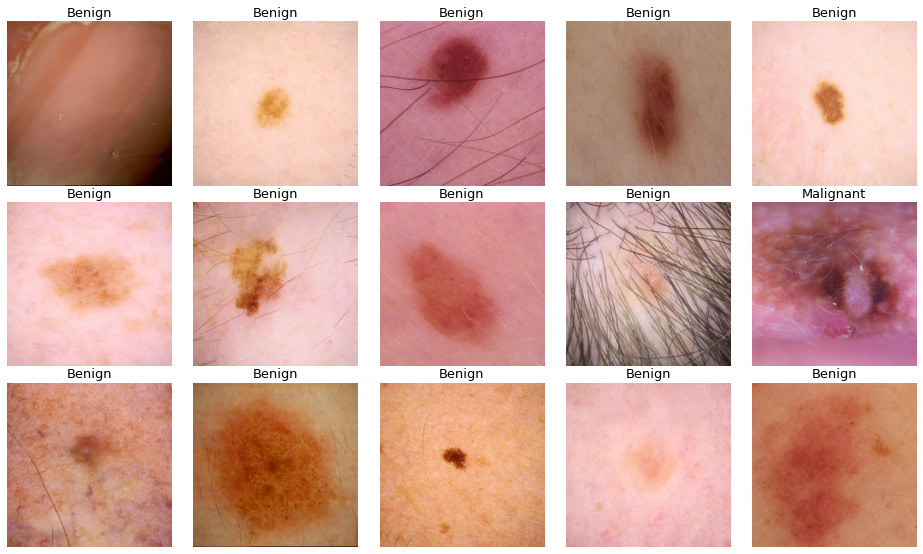

In [ ]:
example_batch = iter(example_dataset) 
image_batch, label_batch = next(example_batch)
# because Xception needs a special kind op preprocessing, which plt cannot display correctly,
# we do some image processing for plt here
images = [(x / 255) for x in image_batch]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((images, labels), unbatched=True)

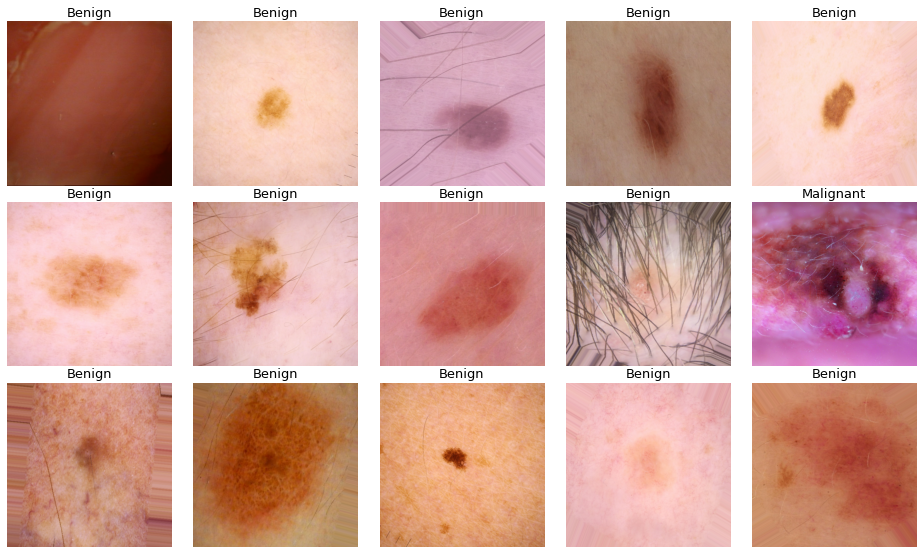

In [ ]:
augmented_images = [augment_image(x, augment=True) for x in images]
augmented_images = [np.clip(x, 0, 1) for x in augmented_images]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((augmented_images, labels), unbatched=True)

In [ ]:
# images are in float32 format with values between 0 and 255
for i in range(10):
    image = image_batch[i]
    print("min:", np.min(image), " -  max:", np.max(image))

print(image.dtype)

min: 0.0  -  max: 216.3125
min: 36.4375  -  max: 255.0
min: 22.75  -  max: 220.25
min: 15.5  -  max: 191.9375
min: 14.4375  -  max: 255.0
min: 44.375  -  max: 255.0
min: 1.4375  -  max: 252.3125
min: 44.6875  -  max: 247.5
min: 22.0  -  max: 249.75
min: 20.5625  -  max: 241.375
<dtype: 'float32'>


# Model Creation

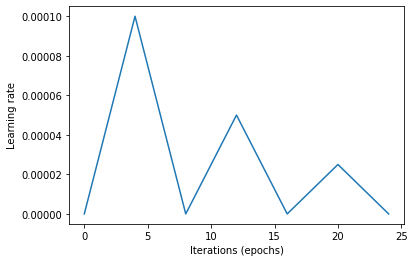

In [ ]:
mode='triangular2'
step_size=4.
clr_callback = get_lr_callback(mode, LR_MIN, LR_MAX, step_size)
plot_clr(mode, LR_MIN, LR_MAX, step_size, EPOCHS)

callbacks = [clr_callback]

In [ ]:
def get_model_parameters(lr):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = 'binary_crossentropy'
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
    ]

    return loss, metrics, optimizer

In [ ]:
def compile_model(model):
    loss, metrics, optimizer = get_model_parameters(LR_START)
    if tpu:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            # Reduce python overhead, and maximize the performance of your TPU
            # Anything between 2 and `steps_per_epoch` could help here.
            steps_per_execution=5,
        )
    else:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
        )

    return model


def build_model():
    output_bias = None
    if initial_bias is not None:
        output_bias = tf.keras.initializers.Constant(initial_bias)

    i = tf.keras.layers.Input([DIM, DIM, 3], dtype = tf.float32)
    x = tf.keras.applications.xception.preprocess_input(i)
    base_model = tf.keras.applications.Xception(
        input_shape=(DIM, DIM, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    x = base_model(x)
    pretrained_model = tf.keras.Model(inputs=[i], outputs=[x], name="xception")

    model = tf.keras.models.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', bias_initializer=output_bias)
    ])

    model = compile_model(model)

    return model


def reset_model():
    model = tf.keras.models.load_model("stage_0.h5")
    model.load_weights("stage_0.hdf5")
    return model

In [ ]:
# Clear the session - this helps when we are creating multiple models
K.clear_session()

# Creating the model in the strategy scope places the model on the TPU
with strategy.scope():
    model = build_model()
    model = compile_model(model)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 20,877,881
Trainable params: 16,401
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#plot_model(base_model, show_shapes=True)

# Initial Model Training

In [ ]:
training_dataset = get_training_dataset(augment=True)
validation_dataset = get_validation_dataset(repeat=True)

In [ ]:
history = model.fit(
    training_dataset,
    epochs=15,
    steps_per_epoch=50,
    validation_steps=10,
    class_weight=class_weight,
    validation_data=validation_dataset,
    verbose=VERBOSE_LEVEL
)

Epoch 1/15
50/50 [==============================] - 88s 2s/step - loss: 0.9421 - accuracy: 0.9155 - auc: 0.4648 - val_loss: 0.4600 - val_accuracy: 0.8477 - val_auc: 0.4397
Epoch 2/15
50/50 [==============================] - 23s 452ms/step - loss: 0.6169 - accuracy: 0.9247 - auc: 0.4721 - val_loss: 0.4995 - val_accuracy: 0.8477 - val_auc: 0.4767
Epoch 3/15
50/50 [==============================] - 23s 461ms/step - loss: 0.4979 - accuracy: 0.9425 - auc: 0.5897 - val_loss: 0.4669 - val_accuracy: 0.8477 - val_auc: 0.5513
Epoch 4/15
50/50 [==============================] - 25s 496ms/step - loss: 0.4392 - accuracy: 0.9589 - auc: 0.6760 - val_loss: 0.4375 - val_accuracy: 0.8477 - val_auc: 0.6303
Epoch 5/15
50/50 [==============================] - 23s 466ms/step - loss: 0.6833 - accuracy: 0.8597 - auc: 0.6901 - val_loss: 0.5144 - val_accuracy: 0.8367 - val_auc: 0.6364
Epoch 6/15
50/50 [==============================] - 21s 428ms/step - loss: 0.6470 - accuracy: 0.6261 - auc: 0.7113 - val_loss: 0

In [ ]:
# save the initially trained model, so we can restore it later
model.save_weights("stage_0.hdf5")
model.save("stage_0.h5")

# Full Training 

In [ ]:
K.clear_session()
with strategy.scope():
    # Make the whole model trainable
    model.trainable = True
    # We need to compile the model again after changing the layers
    model = compile_model(model)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 20,877,881
Trainable params: 20,823,353
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
steps_per_epoch = 200
validation_steps_per_epoch = 40
    
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    verbose=VERBOSE_LEVEL
)

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 9.99999993922529e-09.
200/200 [==============================] - 211s 1s/step - loss: 0.6795 - accuracy: 0.4037 - auc: 0.6458 - val_loss: 1.2101 - val_accuracy: 0.2783 - val_auc: 0.6039
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5007500880747102e-05.
200/200 [==============================] - 92s 458ms/step - loss: 0.4222 - accuracy: 0.7849 - auc: 0.8736 - val_loss: 0.3459 - val_accuracy: 0.8541 - val_auc: 0.7998
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 5.000500095775351e-05.
200/200 [==============================] - 92s 460ms/step - loss: 0.2526 - accuracy: 0.9105 - auc: 0.9565 - val_loss: 0.2765 - val_accuracy: 0.8824 - val_auc: 0.8537
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 7.500249921577051e-05.
200/200 [==============================] - 92s 462ms/step - loss: 0.1904 - accuracy: 0.9326 - auc: 0.9737 - val_loss: 0.

# Model Evaluation

start predicting ...
Precision: 0.4414
Recall: 0.5026
Threshold: 0.1884
F1 Score: 0.47


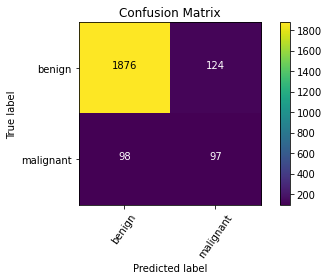

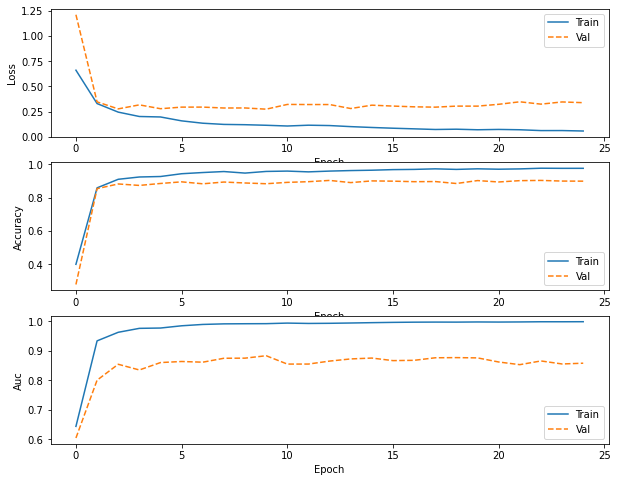

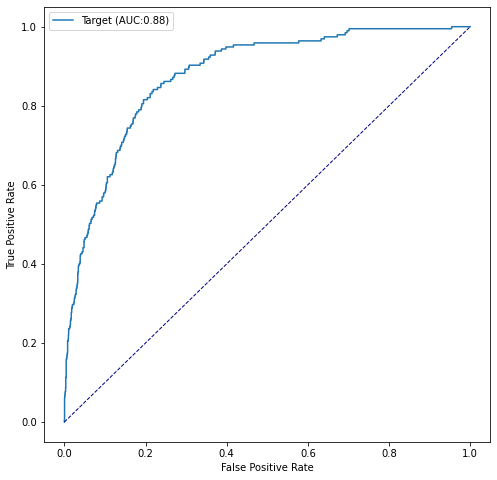

In [45]:
# Get a detailed evaluation from the last fold
example_validation_dataset = get_validation_dataset(repeat=False)
predictions, labels, threshold = evaluate_model(
    model=model, 
    dataset=example_validation_dataset, 
    history=history,
    save_output=SAVE_OUTPUT, 
    timestamp=timestamp
)

# Meta Learner

In [46]:
meta_model = load("/content/melanoma-classification/app/model-server/rf_model.joblib")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [47]:
df = pd.read_csv("/content/melanoma-classification/data/test.csv")
df_test = df.copy()

In [48]:
feature_columns = ['age_approx', 'sex_female', 'sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity']

# getting dummy variables for gender
sex_dummies = pd.get_dummies(df_test['sex'], prefix='sex', dtype="int")
df_test = pd.concat([df_test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(df_test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
df_test = pd.concat([df_test, anatom_dummies], axis=1)

# convert age to int
df_test['age_approx'] = df_test['age_approx'].astype('int')

# dropping not useful columns
df_test.drop(['sex','anatom_site_general_challenge', 'patient_id'], axis=1, inplace=True)

df_test = df_test[feature_columns]

In [49]:
df_test.head(1)

,age_approx,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity
0,70,0,1,0,0,0,0,0,0


In [50]:
meta_predictions = meta_model.predict_proba(df_test)
meta_predictions[0]

array([0.21553638, 0.78446362])

# GH & Submission

In [51]:
%%capture
import os.path
from os import path

if not path.exists("/content/current_metrics.txt"):
    # download the current metrics
    !wget https://raw.githubusercontent.com/SaschaMet/melanoma-classification/master/evaluation/metrics.txt
    !mv /content/metrics.txt.1 /content/current_metrics.txt

In [53]:
print("current metrics")
with open("/content/current_metrics.txt") as json_file:
    current_metrics = json.load(json_file)
print(current_metrics)

current metrics
{'f1score': '0.8199', 'precision': '0.7269', 'recall': '0.9402', 'threshold': '0.2299'}


In [52]:
print("new metrics")
with open("/content/metrics.txt") as json_file:
    metrics = json.load(json_file)
print(metrics)

new metrics
{'f1score': '0.47', 'precision': '0.4414', 'recall': '0.5026', 'threshold': '0.1884'}


In [ ]:
# check if the new model is better than the old one
is_better = True

# if one metric is worse than a metric from the prev model, do not update the model
metrics_to_compare = ['f1score', 'precision', 'recall']
for metric in metrics_to_compare:
    if metrics[metric] < current_metrics[metric]:
        is_better = False

print("New model is an improvement compared to the pre model:", is_better)

In [ ]:
if not is_better:
    sys.exit("Stop execution because of inferior model")

In [54]:
## save model history
with open('history.json', 'w', encoding='utf-8') as f:
    json.dump(str(history.history), f, ensure_ascii=False, indent=4)

In [55]:
## save the model
model.save_weights("final_weights.hdf5")
model.save("final_model.h5")

In [56]:
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('model.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
# create a new model for the predictions
#K.clear_session()
#with strategy.scope():
    #model = tf.keras.models.load_model("/content/final_model.h5")
    #model.load_weights("final_weights.hdf5")
    #model = compile_model(model)

In [57]:
test_ds = get_test_dataset(ordered=True)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

In [59]:
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds, verbose=1, steps=math.ceil(len(test_ids) / BATCH_SIZE))

Computing predictions...
86/86 [==============================] - 14s 164ms/step


In [60]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

Generating submission.csv file...


,image_name,target
0,ISIC_0052060,0.000071
1,ISIC_0297702,0.000327
2,ISIC_0479726,0.190965
3,ISIC_0641371,0.002405
4,ISIC_0808861,0.054347


In [61]:
pred_df.to_csv("./submission.csv", index=False)
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Sub xception"

100% 275k/275k [00:02<00:00, 133kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [62]:
combined_predictions = []
for index, row in pred_df.iterrows():
    image_name = row['image_name']
    target = row['target']
    idx_meta_prediction = df.index[df['image_name'] == image_name].values[0]    
    meta_prediction = meta_predictions[idx_meta_prediction][1]

    combined_prediction = float(target) + (meta_prediction * META_CONTRIBUTION)
    combined_predictions.append(combined_prediction)

pred_df_combined = pd.DataFrame({'image_name': test_ids, 'target': combined_predictions})
pred_df_combined.head()

,image_name,target
0,ISIC_0052060,0.078517
1,ISIC_0297702,0.076041
2,ISIC_0479726,0.270170
3,ISIC_0641371,0.081610
4,ISIC_0808861,0.128537


In [63]:
pred_df_combined.to_csv("./submission_meta.csv", index=False)
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission_meta.csv -m "Sub xception with Meta Model"

100% 351k/351k [00:01<00:00, 183kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [ ]:
sys.exit("")

In [ ]:
## if the model is an improvement, push it!
!cd /content/melanoma-classification && git checkout xception

In [64]:
!mkdir evaluation

for f in glob.glob("/content/*auc.png"):
    os.rename(f, "auc.png")

for f in glob.glob("/content/*cm.png"):
    os.rename(f, "cm.png")

for f in glob.glob("/content/*history.png"):
    os.rename(f, "history.png")
    
shutil.move("/content/model.json", "/content/evaluation/model.json")
shutil.move("/content/history.png", "/content/evaluation/history.png")
shutil.move("/content/history.json", "/content/evaluation/history.json")
shutil.move("/content/cm.png", "/content/evaluation/cm.png")
shutil.move("/content/auc.png", "/content/evaluation/auc.png")
shutil.move("/content/metrics.txt", "/content/evaluation/metrics.txt")
shutil.move("/content/current_metrics.txt", "/content/evaluation/current_metrics.txt")

!rm -rf /content/melanoma-classification/evaluation
!mv /content/evaluation /content/melanoma-classification/evaluation

In [65]:
gh_auth = "/content/drive/MyDrive/Colab Notebooks/_auth/gh_auth.txt"
with open(gh_auth) as f:
    gh_auth = f.read()

!cd /content/melanoma-classification && git config --global user.email "sascha.metzger@outlook.com"
!cd /content/melanoma-classification && git config --global user.name "SaschaMet"

!cd /content/melanoma-classification && git remote remove origin
!cd /content/melanoma-classification && git remote add origin $gh_auth

In [66]:
!cd /content/melanoma-classification && git fetch && git checkout -b xception && git status

From https://github.com/SaschaMet/melanoma-classification
 * [new branch]      efficientNetB5 -> origin/efficientNetB5
 * [new branch]      master         -> origin/master
M	evaluation/auc.png
M	evaluation/cm.png
M	evaluation/current_metrics.txt
M	evaluation/history.png
M	evaluation/metrics.txt
M	evaluation/model.json
Switched to a new branch 'xception'
On branch xception
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   evaluation/auc.png
	modified:   evaluation/cm.png
	modified:   evaluation/current_metrics.txt
	modified:   evaluation/history.png
	modified:   evaluation/metrics.txt
	modified:   evaluation/model.json

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	evaluation/history.json

no changes added to commit (use "git add" and/or "git commit -a")


In [67]:
!cd /content/melanoma-classification && git checkout xception
!cd /content/melanoma-classification && git add .
!cd /content/melanoma-classification && git commit -m "xception"
!cd /content/melanoma-classification && git push --set-upstream origin xception

M	evaluation/auc.png
M	evaluation/cm.png
M	evaluation/current_metrics.txt
M	evaluation/history.png
M	evaluation/metrics.txt
M	evaluation/model.json
Already on 'xception'
[xception 2db89c0] xception
 7 files changed, 4 insertions(+), 3 deletions(-)
 rewrite evaluation/auc.png (98%)
 rewrite evaluation/cm.png (99%)
 create mode 100644 evaluation/history.json
 rewrite evaluation/history.png (99%)
 rewrite evaluation/model.json (85%)
Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 75.62 KiB | 15.12 MiB/s, done.
Total 9 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: 
remote: Create a pull request for 'xception' on GitHub by visiting:
remote:      https://github.com/SaschaMet/melanoma-classification/pull/new/xception
remote: 
To https://github.com/SaschaMet/melanoma-classification.git
 * [new branch]      xception -> xception
Branch 'xception' se

In [68]:
!cd /content/melanoma-classification && git status

On branch xception
Your branch is up to date with 'origin/xception'.

nothing to commit, working tree clean


In [69]:
!zip /content/final_model.h5.zip /content/final_model.h5

  adding: content/final_model.h5 (deflated 8%)


In [70]:
!zip /content/final_weights.hdf5.zip /content/final_weights.hdf5

  adding: content/final_weights.hdf5 (deflated 7%)


In [71]:
from google.colab import files
files.download('/content/final_weights.hdf5.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
files.download('/content/final_model.h5.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>